In [1]:
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.interval.l2_functions import L2Function
from pygeoinf.interval.sobolev_space import Sobolev
import numpy as np
import matplotlib.pyplot as plt

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/random_matrix.py:6: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.linalg import (


In [2]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="muted")

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:96: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


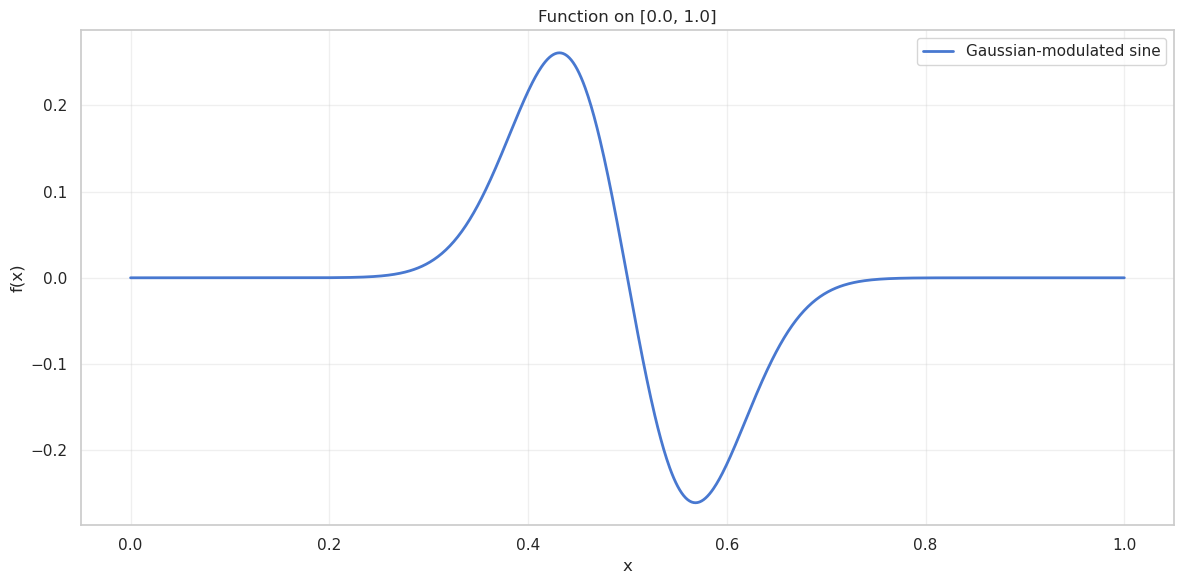

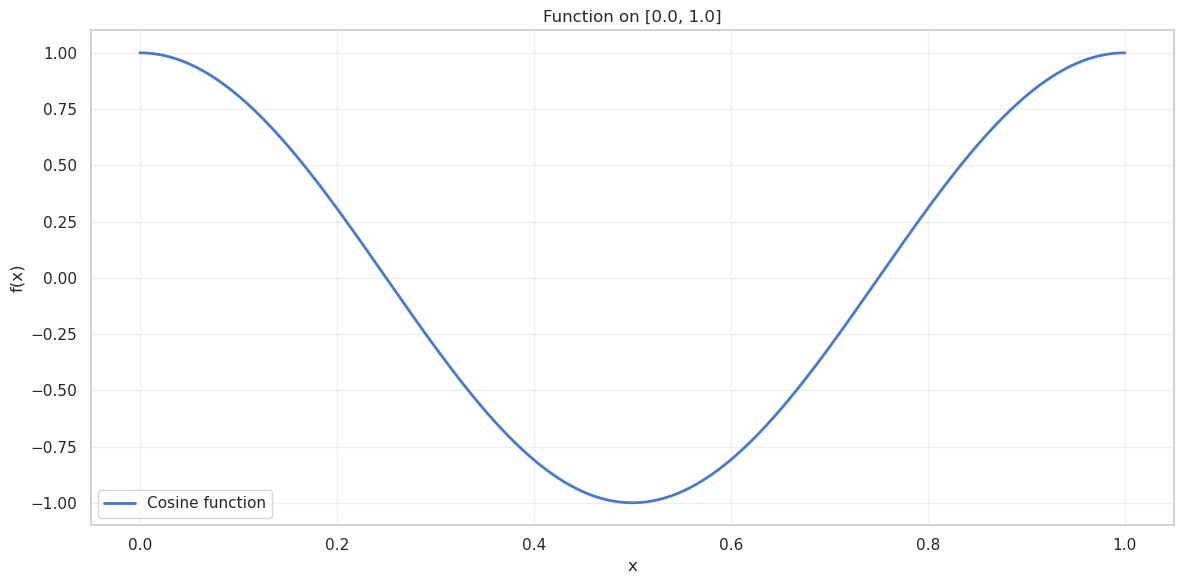

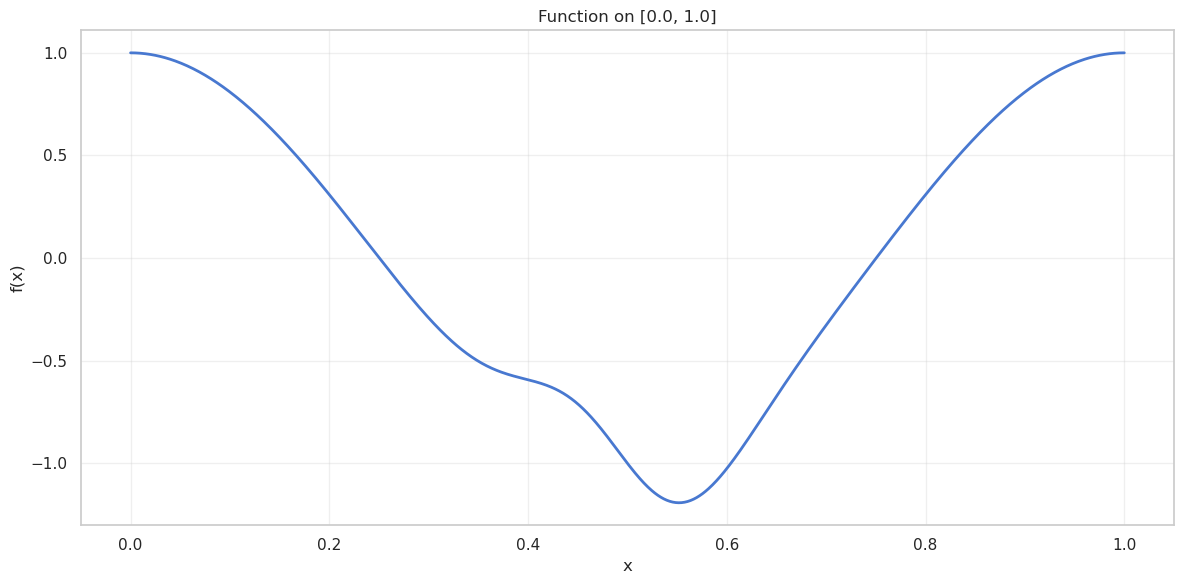

In [3]:
L2 = L2Space(5, basis_type="fourier", interval=[0, 1])
H1 = Sobolev(5, 1, basis_type="fourier", interval=(0, 1))
H2 = Sobolev(5, 2, basis_type="fourier", interval=(0, 1))

def f_eval(x):
    return np.exp(-((x - 1/2)**2)/0.01) * np.sin(2 * np.pi * x)

def constant_eval(x):
    return np.ones_like(x)
const = L2Function(L2, evaluate_callable=constant_eval, name="Constant function")
f = L2Function(L2, evaluate_callable=f_eval, name="Gaussian-modulated sine")
g = L2Function(H1, evaluate_callable=lambda x: np.cos(2 * np.pi * x), name="Cosine function")
# Using the built-in plot method
f.plot(n_points=1000, figsize=(12, 6))
g.plot(n_points=1000, figsize=(12, 6))
(f+g).plot(n_points=1000, figsize=(12, 6))
plt.show()

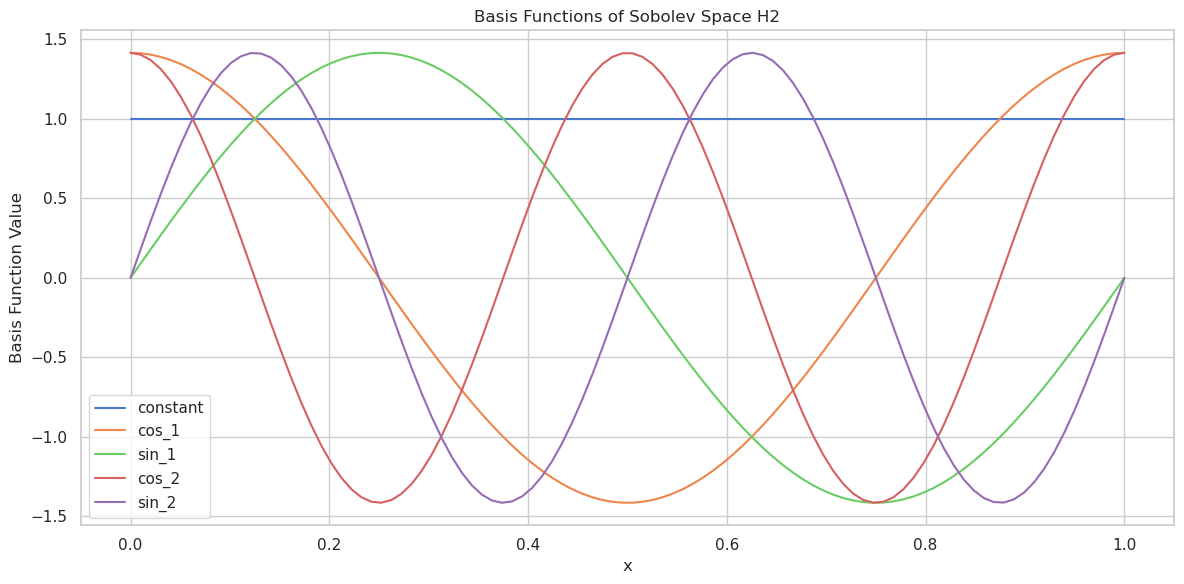

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
for base in H2.basis_functions:
    ax.plot(H2.domain.uniform_mesh(100), base.evaluate(H2.domain.uniform_mesh(100)), label=base.name)
ax.set_title("Basis Functions of Sobolev Space H2")
ax.set_xlabel("x")
ax.set_ylabel("Basis Function Value")
ax.legend()
plt.tight_layout()
plt.show()

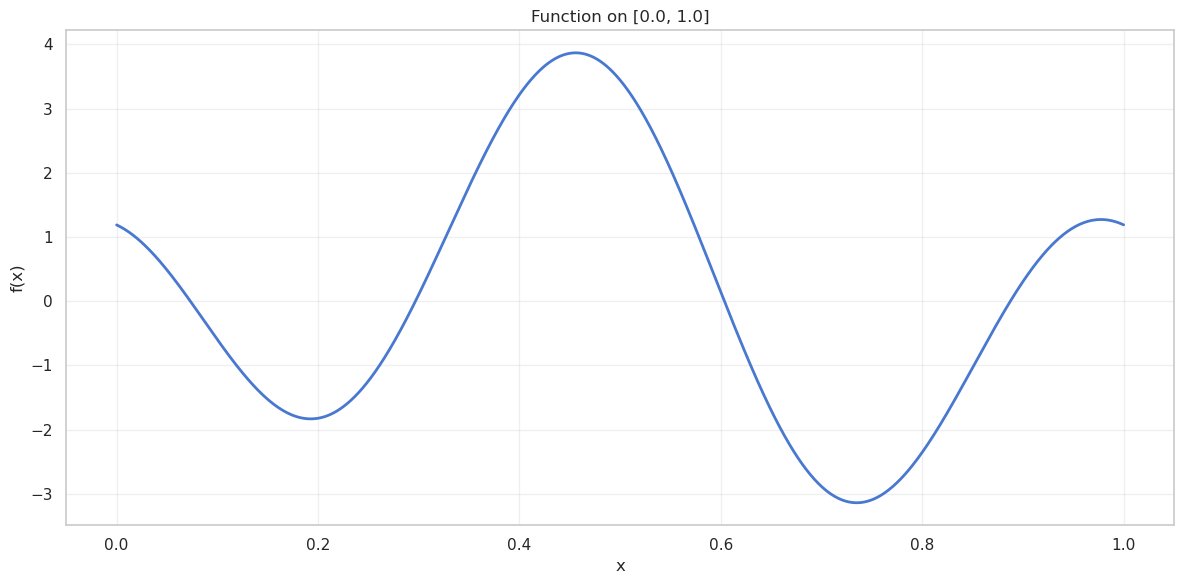

In [5]:
random_f = H2.random()
random_f.plot(n_points=1000, figsize=(12, 6))
plt.show()

In [11]:
# Import the new modular Laplacian operator
import importlib
from pygeoinf.interval.laplacian_inverse_operator import LaplacianInverseOperator

# Create operator with native solver (no external dependencies)
print("Creating Laplacian operator with native FEM solver:")
laplacian_op_native = LaplacianInverseOperator(
    L2,
    mesh_resolution=200,
    boundary_conditions="dirichlet",
    solver_type="native"  # Pure Python implementation
)

Creating Laplacian operator with native FEM solver:
LaplacianInverseOperator initialized with native solver, dirichlet BCs


In [12]:
# Test the native solver
print("Testing native solver:")
solution_native = laplacian_op_native(L2Function(L2, evaluate_callable=lambda x: np.sin(2 * np.pi * x), name="Sine function"))

# Use the native solution for further analysis
solution = solution_native

Testing native solver:


<Axes: title={'center': 'Function on [0.0, 1.0]'}, xlabel='x', ylabel='f(x)'>

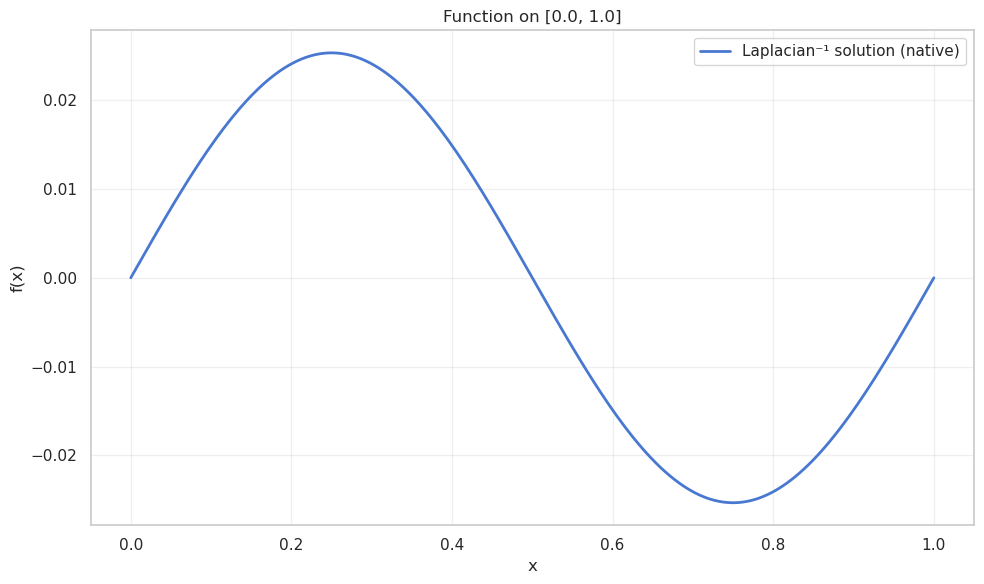

In [13]:
solution.plot()

=== Modular Solver Architecture Demo ===

Testing sin(2πx) with different solvers and boundary conditions:

LaplacianInverseOperator initialized with native solver, dirichlet BCs
Dirichlet BCs: u(0) = -0.000000, u(1) = 0.000000
LaplacianInverseOperator initialized with native solver, neumann BCs
Neumann BCs: u(0) = 0.079551, u(1) = -0.079551
LaplacianInverseOperator initialized with native solver, periodic BCs
Periodic BCs: u(0) = 0.027032, u(1) = 0.023943
  Periodic constraint: |u(0) - u(1)| = 3.09e-03


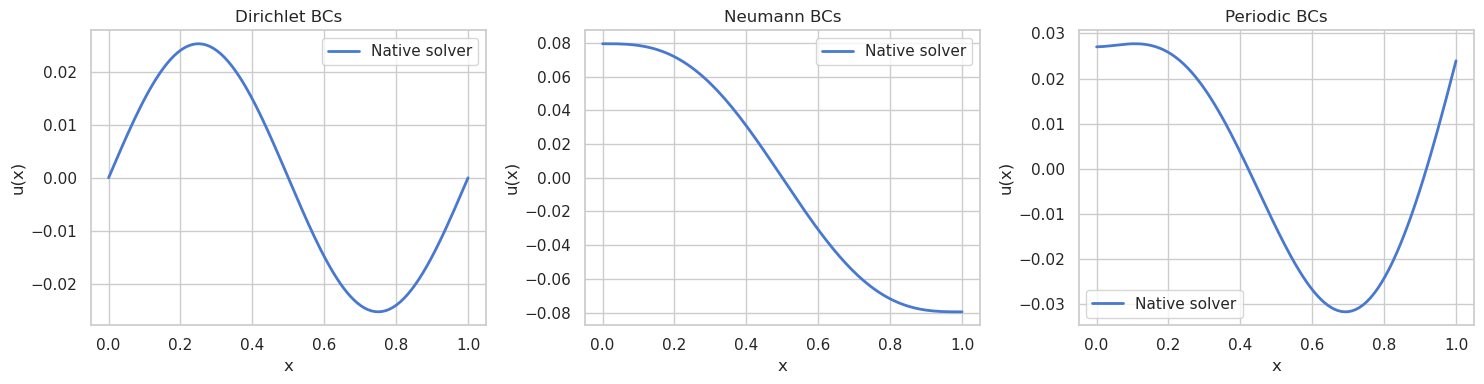


✓ Native solver requires no external dependencies
✓ Modular design allows easy switching between solver backends
✓ All boundary conditions properly implemented


In [14]:
# Demonstrate solver switching and comparison
print("=== Modular Solver Architecture Demo ===")
print()

# Test with a periodic function
test_func = L2Function(L2, evaluate_callable=lambda x: np.sin(2 * np.pi * x), name="sin(2πx)")

print("Testing sin(2πx) with different solvers and boundary conditions:")
print()

boundary_conditions = ['dirichlet', 'neumann', 'periodic']
x_test = np.linspace(0, 1, 1000)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, bc in enumerate(boundary_conditions):
    # Create native solver
    op_native = LaplacianInverseOperator(L2, mesh_resolution=100,
                                        boundary_conditions=bc, solver_type='native')

    # Solve
    solution = op_native(test_func)
    u_vals = solution.evaluate(x_test)

    # Plot
    ax = axes[i]
    ax.plot(x_test, u_vals, 'b-', linewidth=2, label='Native solver')
    ax.set_title(f'{bc.capitalize()} BCs')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
    ax.grid(True)
    ax.legend()

    # Print boundary values
    print(f"{bc.capitalize()} BCs: u(0) = {u_vals[0]:.6f}, u(1) = {u_vals[-1]:.6f}")

    if bc == 'periodic':
        diff = abs(u_vals[0] - u_vals[-1])
        print(f"  Periodic constraint: |u(0) - u(1)| = {diff:.2e}")

plt.tight_layout()
plt.show()

print()
print("✓ Native solver requires no external dependencies")
print("✓ Modular design allows easy switching between solver backends")
print("✓ All boundary conditions properly implemented")